In [15]:
import cv2
import load_img
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.exposure import rescale_intensity
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import pickle as pk

### Load Data

In [16]:
loader = load_img.load_img()
X, Y, df = loader.load_im('Caltech_face\\')
le = LabelEncoder()
Y = le.fit_transform(Y)
print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)
df.head()

X.shape =  (700, 25600)
Y.shape =  (700,)


,Name,Quantity
0,1,20
1,10,20
2,11,20
3,12,20
4,13,20


### Split Data

In [17]:
def split_data(X, Y):
    split_index = list(range(0,X.shape[0], 20))
    X_test = X[split_index]
    Y_test = Y[split_index]

    # preprare training set by removing items in test set
    X_train = X.copy()
    Y_train =  Y.copy()
    for i in split_index[::-1]:
        X_train  = np.delete(X_train,i,axis = 0 )
        Y_train = np.delete(Y_train,i,axis = 0 )
    print('X_train: ', X_train.shape)
    print('Y_train: ', Y_train.shape)
    print('X_test: ', X_test.shape)
    print('Y_test: ', Y_test.shape)
    return X_train, Y_train, X_test, Y_test

def split_data_random(X, Y):
    X_train, X_test, Y_train ,Y_test = train_test_split(X, Y, test_size=0.15)
    print('X_train: ', X_train.shape)
    print('Y_train: ', Y_train.shape)
    print('X_test: ', X_test.shape)
    print('Y_test: ', Y_test.shape)
    return X_train, Y_train, X_test, Y_test

In [18]:
X_train, Y_train, X_test, Y_test = split_data(X, Y)

X_train:  (665, 25600)
Y_train:  (665,)
X_test:  (35, 25600)
Y_test:  (35,)


### PCA

In [19]:
pca = PCA(svd_solver="randomized", n_components= 120,	whiten=True)
#pca = pk.load(open("model\\PCA.pkl",'rb'))

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pk.dump(pca, open("model\\PCA_test.pkl","wb"))

In [20]:
print('X_train_pca: ', X_train_pca.shape)
print('X_test_pca: ', X_test_pca.shape)

X_train_pca:  (665, 120)
X_test_pca:  (35, 120)


#### Mean_face

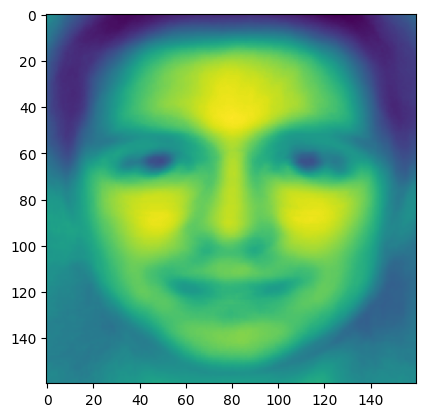

In [21]:
mean = pca.mean_
mean = rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
plt.imshow(mean.reshape(160,160))

### SVM

In [22]:

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],  
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
              'kernel': ['rbf']} 
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, refit = True)
svm = svm.fit(X_train_pca, Y_train)
pk.dump(svm, open('model\\SVM_test.sav', 'wb'))
print("Best estimator found by grid search:")
print(svm.best_estimator_)

# load the model from disk
#svm = pk.load(open('model\\finalized_model.sav', 'rb'))

In [23]:
Y_predict = svm.predict(X_test_pca)
Y_predict

array([ 0,  1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31,  2,  3,  4,  5,  6,  7, 12,  9, 10, 11, 12, 32, 33,
       34], dtype=int64)

### SVM Results

In [24]:
count = 0
for i in range(len(Y_test)):
    if Y_test[i] == Y_predict[i]:
        count += 1
print((count/len(Y_test)) * 100)

97.14285714285714


In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### KNN

In [26]:
from sklearn import neighbors, datasets
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, p = 2) 
knn.fit(X_train_pca, Y_train)

KNeighborsClassifier(n_neighbors=1)

In [27]:
Y_predict = knn.predict(X_test_pca)
Y_predict

array([ 0,  1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31,  2,  3, 25,  5,  6,  7,  8,  9, 20, 11, 12, 32, 33,
       34], dtype=int64)

### KNN Result

In [28]:
count = 0
for i in range(len(Y_test)):
    if Y_test[i] == Y_predict[i]:
        count += 1
print((count/len(Y_test)) * 100)

94.28571428571428
